# Data Generation

In [8]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

dim_theta = 10
data_num = 1000
scale = .1

theta_true = np.ones((dim_theta,1))
print('True theta:', theta_true.reshape(-1))

A = np.random.uniform(low=-1.0, high=1.0, size=(data_num,dim_theta))
y_data = A @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(data_num, 1))

A_test = np.random.uniform(low=-1.0, high=1.0, size=(50, dim_theta))
y_test = A_test @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(50, 1))

True theta: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Solving for the exact mean squared loss (solving Ax = b)

In [9]:
# print('Not implemented.')

'''
Hints:
1. See the least squares solution to Ax = b (when it is covered in lecture).

2. Use Numpy functions like Numpy's linear algebra functions to solve for x in Ax = b.
In fact, the linear algebra module is already imported with ```import numpy.linalg as la```.

3. Use the defined variable A in Ax = b. Use y_data as b. Use theta_pred as x.
'''
# theta_pred = NotImplemented # TODO: Implement the analytical solution
# theta_pred = la.inv(A.T @ A) @ A.T @ y_data
theta_pred = la.lstsq(A, y_data, rcond=None)[0]

print('Empirical theta', theta_pred.reshape(-1))

Empirical theta [0.99946012 1.00602825 1.00550761 1.00263759 0.99292976 0.99315184
 0.9928867  1.00701835 1.00216259 0.99415699]


# SGD Variants Noisy Function

In [12]:
batch_size = 1
max_iter = 1000
lr = 0.001
theta_init = np.random.random((10,1)) * 0.1

In [11]:
def noisy_val_grad(theta_hat, data_, label_, deg_=2.):
    gradient = np.zeros_like(theta_hat)
    loss = 0

    for i in range(data_.shape[0]):
        x_ = data_[i, :].reshape(-1,1)
        y_ = label_[i, 0]
        err = np.sum(x_ * theta_hat) - y_

        # print('Not implemented.')

        '''
        Hints:
        1. Find the gradient and loss for each data point x_.
        2. For grad, you need err, deg_, and x_.
        3. For l, you need err and deg_ only.
        4. Checkout the writeup for more hints.
        '''

        grad = deg_ * (abs(err) ** (deg_ - 1)) * np.sign(err) * x_
        l = abs(err) ** deg_

        loss += l / data_.shape[0]
        gradient += grad / data_.shape[0]

    return loss, gradient

# Running SGD Variants

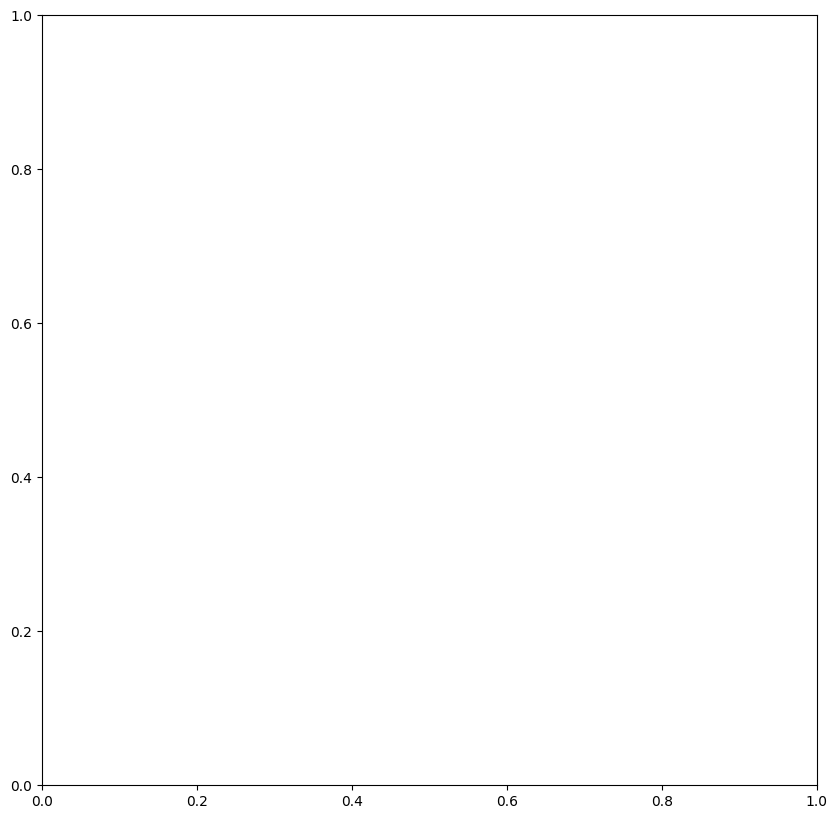

In [37]:
#@title Parameters
deg_ = 2. #@param {type: "number"}
num_rep = 5 #@param {type: "integer"}
max_iter = 1000 #@param {type: "integer"}
fig, ax = plt.subplots(figsize=(10,10))
best_vals = {}
test_exp_interval = 50 #@param {type: "integer"}
grad_artificial_normal_noise_scale = 0. #@param {type: "number"}

adam 0
adam done
sgd 0
sgd done
adagrad 0
adagrad done


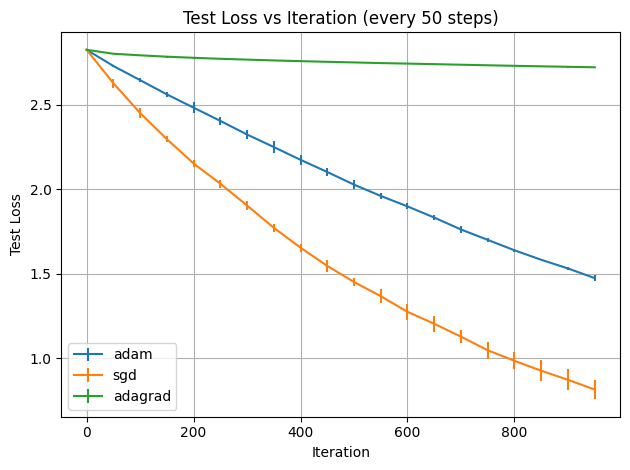

In [38]:
for method_idx, method in enumerate(['adam', 'sgd', 'adagrad']):
    test_loss_mat = []
    train_loss_mat = []

    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(method, replicate)

        if method == 'adam':
            beta_1 = 0.9
            beta_2 = 0.999
            m = np.zeros_like(theta_hat)
            v = np.zeros_like(theta_hat)
            epsilon = 1e-8

        if method == 'adagrad':
            epsilon = 1e-8
            squared_sum = np.zeros_like(theta_hat)

        theta_hat = theta_init.copy()
        test_loss_list = []
        train_loss_list = []

        for t in range(max_iter):
            idx = np.random.choice(data_num, batch_size) # Split data
            train_loss, gradient = noisy_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=deg_)
            artificial_grad_noise = np.random.randn(10, 1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10, 1)) - 0.5) * 0.
            gradient += artificial_grad_noise
            train_loss_list.append(train_loss)

            if t % test_exp_interval == 0:
                test_loss, _ = noisy_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=deg_)
                test_loss_list.append(test_loss)

            if method == 'adam':
                m = beta_1 * m + (1 - beta_1) * gradient
                v = beta_2 * v + (1 - beta_2) * (gradient ** 2)
                m_hat = m / (1 - beta_1 ** (t + 1))
                v_hat = v / (1 - beta_2 ** (t + 1))
                theta_hat -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

            elif method == 'adagrad':
                squared_sum += gradient ** 2
                theta_hat -= lr * gradient / (np.sqrt(squared_sum) + epsilon)

            elif method == 'sgd':
                theta_hat -= lr * gradient

        if replicate == 9 and method in ['adam', 'sgd']:
            print(f"Final theta for {method}, replicate={replicate}:\n{theta_hat.flatten()}")

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)

    print(method, 'done')

    x_axis = np.arange(max_iter)[::test_exp_interval]
    test_loss_np = np.array(test_loss_mat)
    test_loss_mean = np.mean(test_loss_np, axis=0)
    test_loss_se = np.std(test_loss_np, axis=0) / np.sqrt(num_rep)

    plt.errorbar(x_axis, test_loss_mean, yerr=2.5 * test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)

plt.title("Test Loss vs Iteration (every 50 steps)")
plt.xlabel("Iteration")
plt.ylabel("Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
best_vals = { k: int(v * 1000) / 1000. for k,v in best_vals.items() } # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {deg_},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')